# Proximal solvers

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.utils import moreau

## Proximal point algorithm 

Let's first use the Proximal point algorithm to solve this problem

$$
\mathbf{x} = arg min_\mathbf{x} \frac{1}{2} \mathbf{x}^T\mathbf{A} \mathbf{x} + \mathbf{b}^T \mathbf{x} + c
$$

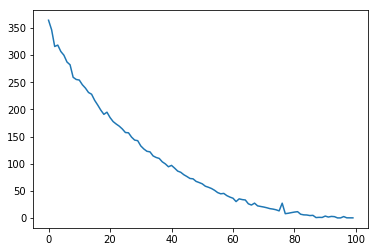

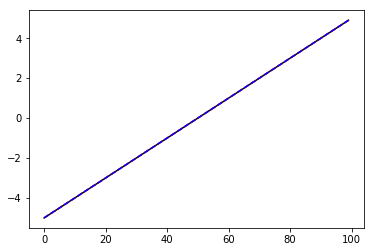

In [2]:
np.random.seed(10)

tau = 1
x = np.arange(-5, 5, 0.1)
nx = len(x)

A = np.random.normal(0, 1, (nx, nx))
A = A.T @ A
plt.figure()
plt.plot(np.linalg.eig(A)[0])
b = A @ x

quad = Quadratic(Op=MatrixMult(A), b=-b, niter=30)

xinv = solve(A, b)
xinv1 = ProximalPoint(quad, x0=np.zeros_like(x), tau=tau, niter=200, show=False)

plt.figure()
plt.plot(x, 'k')
plt.plot(xinv, '--r')
plt.plot(xinv1, '--b');

In [3]:
%timeit solve(A, b)
%timeit ProximalPoint(quad, x0=np.zeros_like(x), tau=tau, niter=40)

303 µs ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.7 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's now use the Proximal point algorithm to solve a simple unconstrained L2 cost function with a dense matrix

$$
\mathbf{x} = arg min_\mathbf{x} \frac{1}{2} ||\mathbf{A} \mathbf{x} - \mathbf{b} ||_2^2
$$

Using a dense matrix allows for an exact evaluation of the proximal of the cost function

Proximal point algorithm
---------------------------------------------------------
Proximal operator: <class 'pyproximal.proximal.L2.L2'>
tau = 1.000000e+00	niter = 10

   Itn       x[0]        f
     1  -4.98092e+00   3.737e+00
     2  -5.00001e+00   2.065e-03
     3  -5.00000e+00   2.428e-06
     4  -5.00000e+00   3.645e-09
     5  -5.00000e+00   6.357e-12
     6  -5.00000e+00   1.230e-14
     7  -5.00000e+00   2.552e-17
     8  -5.00000e+00   5.546e-20
     9  -5.00000e+00   1.245e-22
    10  -5.00000e+00   3.700e-25

Total time (s) = 0.01
---------------------------------------------------------



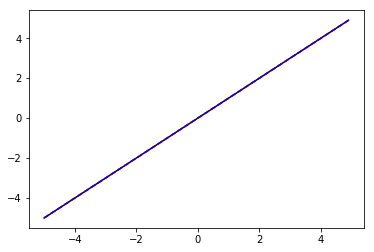

In [4]:
tau = 1
x = np.arange(-5, 5, 0.1)
nx = len(x)
ny = nx * 2

A = np.random.normal(0, 1, (ny, nx))
b = A @ x

quad = L2(Op=MatrixMult(A), b=b, niter=5)

xinv = lsqr(A, b, iter_lim=100)[0]
xinv1 = ProximalPoint(quad, x0=np.zeros_like(x), tau=tau, niter=10, show=True)

plt.plot(x, x, 'k')
plt.plot(x, xinv, '--r')
plt.plot(x, xinv1, '--b');

We now complicate our problem by considering a linear operator that applies convolution. Here we need to rely on iterative solvers (eg lsqr) to solve the proximal

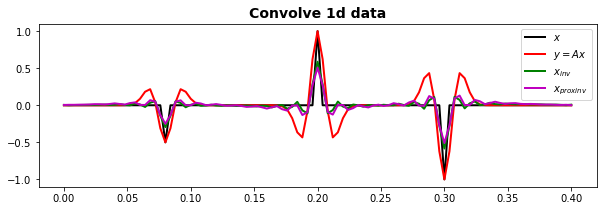

In [5]:
tau = 1
nt = 101
dt = 0.004
t = np.arange(nt)*dt
h, th, hcenter = ricker(t[:101], f0=30)

x = np.zeros(nt)
x[nt//5] = -.5
x[nt//2] = 1
x[3*nt//4] = -1

Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
y = Cop*x

xinv = Cop / y

l2 = L2(Op=Cop, b=y, niter=30)
xinv = lsqr(Cop, y, damp=1e-1, iter_lim=100)[0]
xinv1 = ProximalPoint(l2, x0=np.zeros_like(x), tau=tau, niter=10)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, y, 'r', lw=2, label=r'$y=Ax$')
ax.plot(t, xinv, 'g', lw=2, label=r'$x_{inv}$')
ax.plot(t, xinv1, 'm', lw=2, label=r'$x_{proxinv}$')
ax.set_title('Convolve 1d data', fontsize=14, fontweight='bold')
ax.legend();

## Proximal gradient solver

Let's use the Proximal gradient algorithm to solve this problem

$$
\mathbf{x} = arg min_\mathbf{x} \frac{1}{2} ||\mathbf{A} \mathbf{x} - \mathbf{b} ||_2^2 + \epsilon ||\mathbf{x}||_1
$$

In [6]:
def callback(x):
    xinv_hist.append(x)

Let's start with a random A dense matrix

Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.308768e-03	beta=5.000000e-01
epsg = 5.000000e-01	niter = 200	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1  -1.20486e-02   7.275e+01   4.038e+00   7.477e+01
     2  -1.63495e-02   4.034e+01   5.448e+00   4.307e+01
     3  -1.64210e-02   2.602e+01   6.141e+00   2.909e+01
     4  -1.51832e-02   1.829e+01   6.479e+00   2.153e+01
     5  -1.39025e-02   1.360e+01   6.643e+00   1.692e+01
     6  -1.27554e-02   1.051e+01   6.727e+00   1.387e+01
     7  -1.18756e-02   8.362e+00   6.757e+00   1.174e+01
     8  -1.13155e-02   6.812e+00   6.759e+00   1.019e+01
     9  -1.09520e-02   5.656e+00   6.747e+00   9.030e+00
    10  -1.06723e-02   4.769e+00   6.720e+00   8.130e+00
    11  -1.04869e-02   4.074e+00   6.680e+00   7.414e+00
    21  -1.00191e-02   1.330e+00   6

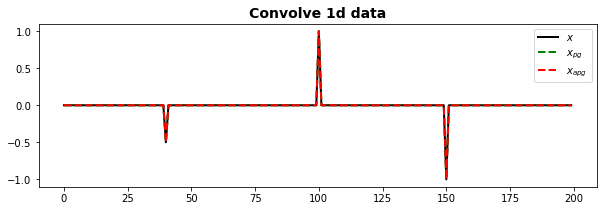

In [7]:
ny, nx = 200, 200
A = np.random.normal(0, 1, (ny, nx))

x = np.zeros(nx)
x[nx//5] = -.5
x[nx//2] = 1
x[3*nx//4] = -1

b = A @ x
Op=MatrixMult(A)

l1 = L1()
l2 = L2(Op=Op, b=b)

tau= 1./np.max(np.linalg.eig(np.dot(Op.A.T, Op.A))[0])
epsg = 0.5
niter = 200
xinv_hist = []
xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros_like(x), epsg=epsg, niter=niter, 
                       callback=callback, show=True)
xpg_hist = xinv_hist
xinv_hist = []
xapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros_like(x), 
                                   epsg=epsg, niter=niter, callback=callback, show=True)
xapg_hist = xinv_hist

fig, ax = plt.subplots(1, 1, figsize=(10, 3)) 
ax.plot(x, 'k', lw=2, label=r'$x$')
ax.plot(xpg, '--g', lw=2, label=r'$x_{pg}$')
ax.plot(xapg, '--r', lw=2, label=r'$x_{apg}$')
ax.set_title('Convolve 1d data', fontsize=14, fontweight='bold')
ax.legend();

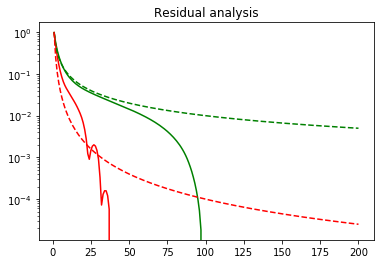

In [8]:
exactnorm = l2(x) + epsg * l1(x)
l2pg = np.array([l2(xpg) + epsg * l1(xpg)  for xpg in xpg_hist])
l2apg = np.array([l2(xapg) + epsg * l1(xapg)  for xapg in xapg_hist])

plt.plot()
plt.semilogy(np.arange(1, niter + 1), (l2pg - exactnorm) / l2pg[0], 'g')
plt.semilogy(np.arange(1, niter + 1), (l2apg - exactnorm) / l2apg[0], 'r')
plt.semilogy(np.arange(1, niter + 1), 1. / np.arange(1, niter + 1), '--g')
plt.semilogy(np.arange(1, niter + 1), 1. / np.arange(1, niter + 1)**2, '--r')
plt.title('Residual analysis');

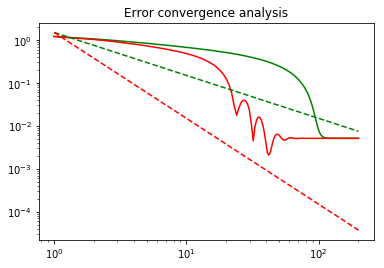

In [9]:
errorpg = np.array([np.linalg.norm(x-xpg)  for xpg in xpg_hist])
errorapg = np.array([np.linalg.norm(x-xapg)  for xapg in xapg_hist])

plt.figure()
plt.loglog(np.arange(1, niter + 1), errorpg, 'g')
plt.loglog(np.arange(1, niter + 1), errorapg, 'r')
plt.loglog(np.arange(1, niter + 1), np.linalg.norm(x) / np.arange(1, niter + 1), '--g')
plt.loglog(np.arange(1, niter + 1), np.linalg.norm(x) / np.arange(1, niter + 1)**2, '--r')
plt.title('Error convergence analysis');

We go back to our convolution problem, but now we can add a sparsity regularization 

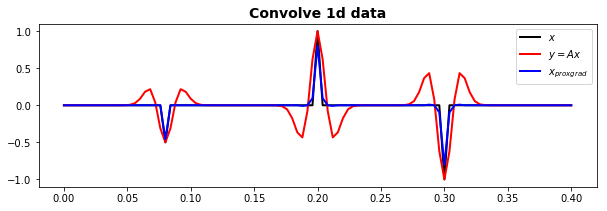

In [10]:
tau = 1
nt = 101
dt = 0.004
t = np.arange(nt)*dt
h, th, hcenter = ricker(t[:101], f0=30)

x = np.zeros(nt)
x[nt//5] = -.5
x[nt//2] = 1
x[3*nt//4] = -1

Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
y = Cop*x

l1 = L1()
l2 = L2(Op=Cop, b=y)

tau= 1./(Cop.H*Cop).eigs(neigs=1, which='LM') # optimal tau=1/maxeig(Cop^H Cop)
epsg = 0.1
xinv_hist = []
xinv2 = ProximalGradient(l2, l1, tau=tau, x0=np.zeros_like(x), epsg=epsg, niter=100, callback=callback)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, y, 'r', lw=2, label=r'$y=Ax$')
ax.plot(t, xinv2, 'b', lw=2, label=r'$x_{proxgrad}$')
ax.set_title('Convolve 1d data', fontsize=14, fontweight='bold')
ax.legend();

## Quadratic program with box constraints

Let's now use it to solve a constrained problem

$$
\mathbf{x} = arg min_\mathbf{x} \frac{1}{2} \mathbf{x}^T \mathbf{A} \mathbf{x} + \mathbf{b}^T \mathbf{x} \quad s.t. \quad \mathbf{x} \in I_{Box}
$$

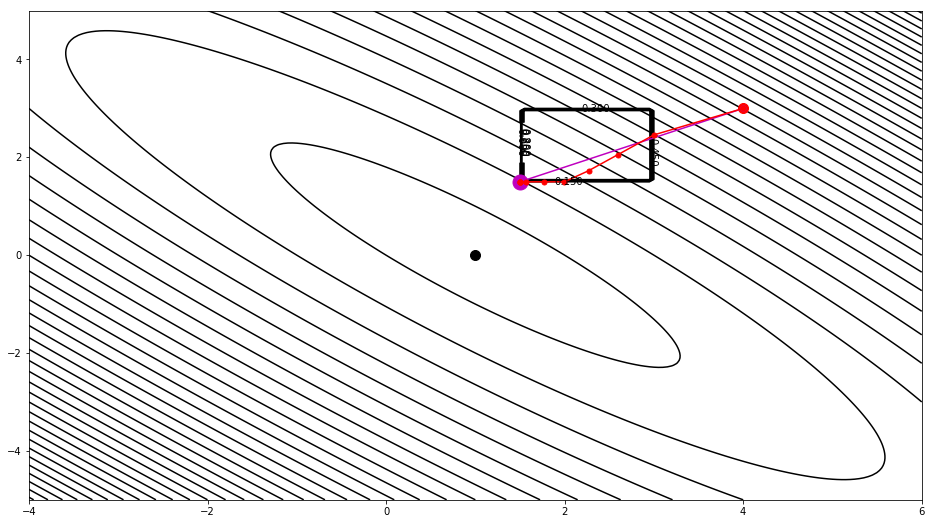

In [11]:
def callback(x):
    mhist.append(x)

# linear term
m = np.array([1, 0])
G = np.array([[10., 9.], 
              [9., 10.]])
d = np.dot(G, m)

# cost function grid
nm1, nm2 = 201, 201
m_min, m_max = (m[0] - 5, m[1] - 5), (m[0] + 5, m[1] + 5)
m1, m2 = np.linspace(m_min[0], m_max[0], nm1), np.linspace(m_min[1], m_max[1], nm2)
m1, m2 = np.meshgrid(m1, m2, indexing='ij')
mgrid = np.vstack((m1.ravel(), m2.ravel()))
J = 0.5 * np.sum(mgrid * np.dot(G, mgrid), axis=0) - np.dot(d, mgrid)
J = J.reshape(nm1, nm2)

# indicator term
lower=1.5
upper=3
indic = (mgrid > lower) & (mgrid < upper)
indic = indic[0].reshape(nm1, nm2) & indic[1].reshape(nm1, nm2)

# proximal gradient
ind = Box(lower, upper)
l2 = L2(Op=MatrixMult(G), b=d, niter=2)

m0 = np.array([4, 3])
mhist = [m0,]
L = np.max(np.linalg.eig(G)[0]) # max eigenvalue of G
tau_opt = 1. /L
minv_opt = ProximalGradient(l2, ind, tau=tau_opt, x0=m0, epsg=1., niter=10, callback=callback)
mhist_opt = np.array(mhist)
mhist = [m0,]
minv_slow = ProximalGradient(l2, ind, tau=0.0005, x0=m0, epsg=1., niter=10, callback=callback)
mhist_slow = np.array(mhist)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.contour(m1, m2, J, levels=40, colors='k')
cs = ax.contour(m1, m2, indic, colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20)
ax.plot(m0[0], m0[1], '.r', ms=20)
ax.plot(minv_opt[0], minv_opt[1], '.m', ms=30)
ax.plot(mhist_opt[:, 0], mhist_opt[:, 1], '.-m', ms=10)
ax.plot(mhist_slow[:, 0], mhist_slow[:, 1], '.-r', ms=10);

Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
tau = 0.000000e+00	beta=5.000000e-01
epsg = 1.000000e+00	niter = 10	niterback = 10

   Itn       x[0]          f           g       J=f+eps*g
     1   1.88477e+00   5.134e+02   0.000e+00   5.134e+02
     2   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     3   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     4   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     5   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     6   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     7   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     8   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     9   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
    10   1.50000e+00   3.612e+02   0.000e+00   3.612e+02

Total time (s) = 0.01
---------------------------------------------------------



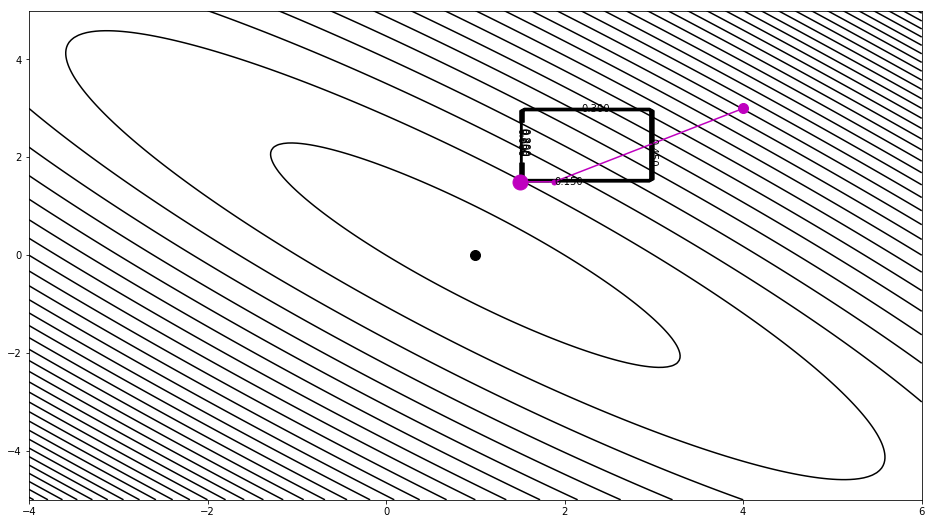

In [12]:
# proximal gradient with backtracking
mhist = [m0,]
minv_back = ProximalGradient(l2, ind, tau=None, x0=m0, epsg=1., niter=10, niterback=10, 
                             callback=callback, show=True)
mhist_back = np.array(mhist)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.contour(m1, m2, J, levels=40, colors='k')
cs = ax.contour(m1, m2, indic, colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20)
ax.plot(m0[0], m0[1], '.m', ms=20)
ax.plot(minv_back[0], minv_back[1], '.m', ms=30)
ax.plot(mhist_back[:, 0], mhist_back[:, 1], '.-m', ms=10);

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
tau = 5.263158e-02	epsg = 1.000000e+00	niter = 10

   Itn       x[0]          f           g       J=f+eps*g
     1   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     2   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     3   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     4   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     5   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     6   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     7   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     8   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     9   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
    10   1.50000e+00   3.612e+02   0.000e+00   3.612e+02

Total time (s) = 0.01
---------------------------------------------------------



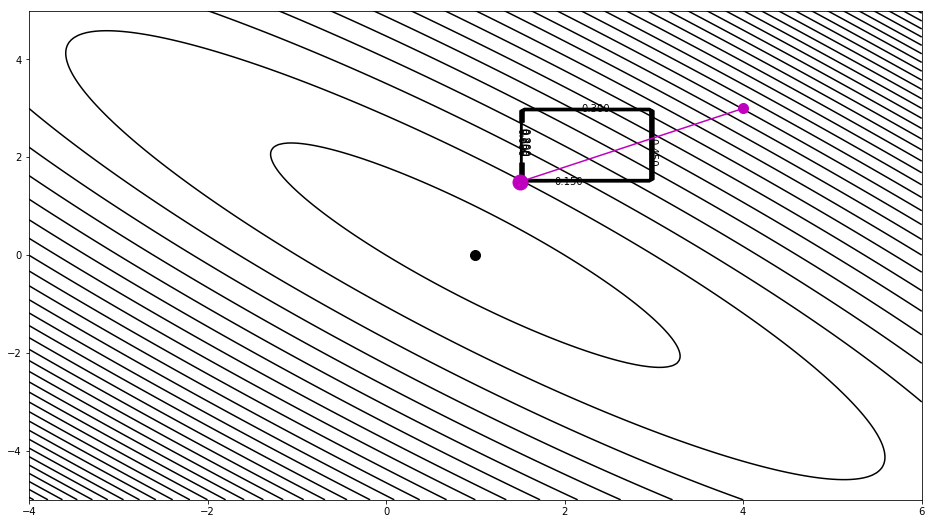

In [13]:
# accelerated proximal gradient
mhist = [m0,]
minv_back = AcceleratedProximalGradient(l2, ind, tau=tau_opt, x0=m0, epsg=1., niter=10,
                                        callback=callback, show=True)
mhist_back = np.array(mhist)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.contour(m1, m2, J, levels=40, colors='k')
cs = ax.contour(m1, m2, indic, colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20)
ax.plot(m0[0], m0[1], '.m', ms=20)
ax.plot(minv_back[0], minv_back[1], '.m', ms=30)
ax.plot(mhist_back[:, 0], mhist_back[:, 1], '.-m', ms=10);

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.Box.Box'>
tau = 0.000000e+00	epsg = 1.000000e+00	niter = 10

   Itn       x[0]          f           g       J=f+eps*g
     1   1.88477e+00   5.134e+02   0.000e+00   5.134e+02
     2   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     3   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     4   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     5   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     6   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     7   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     8   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
     9   1.50000e+00   3.612e+02   0.000e+00   3.612e+02
    10   1.50000e+00   3.612e+02   0.000e+00   3.612e+02

Total time (s) = 0.02
---------------------------------------------------------



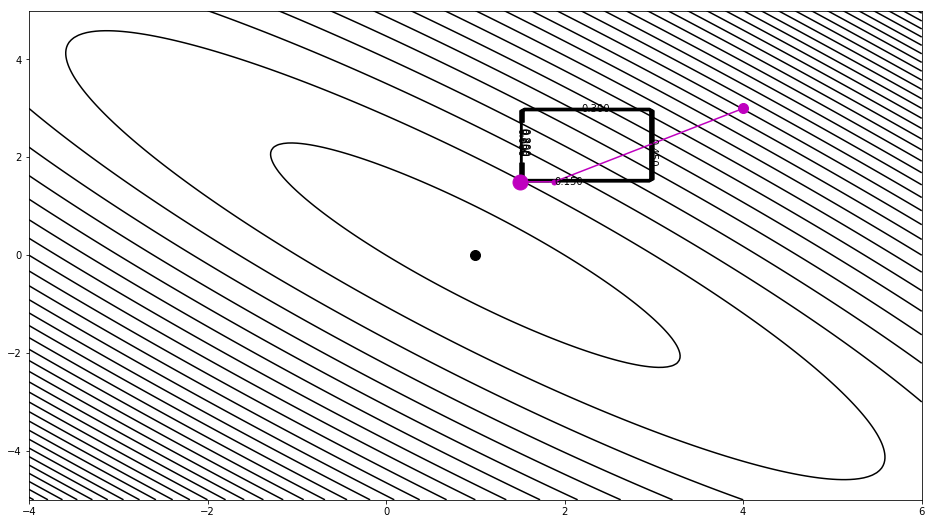

In [14]:
# accelerated proximal gradient with backtracking
mhist = [m0,]
minv_back = AcceleratedProximalGradient(l2, ind, tau=None, x0=m0, epsg=1., niter=10, niterback=30, 
                                        callback=callback, show=True)
mhist_back = np.array(mhist)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.contour(m1, m2, J, levels=40, colors='k')
cs = ax.contour(m1, m2, indic, colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20)
ax.plot(m0[0], m0[1], '.m', ms=20)
ax.plot(minv_back[0], minv_back[1], '.m', ms=30)
ax.plot(mhist_back[:, 0], mhist_back[:, 1], '.-m', ms=10);

And another one

$$
\mathbf{x} = arg min_\mathbf{x} \frac{1}{2}||\mathbf{A} \mathbf{x} - \mathbf{b}|_2^2 \quad s.t. \quad \mathbf{x}^T\mathbf{x} =1
$$

[-0.70710678  0.70710678]
[-0.70710678  0.70710678]
[-0.6958594  0.6958594]


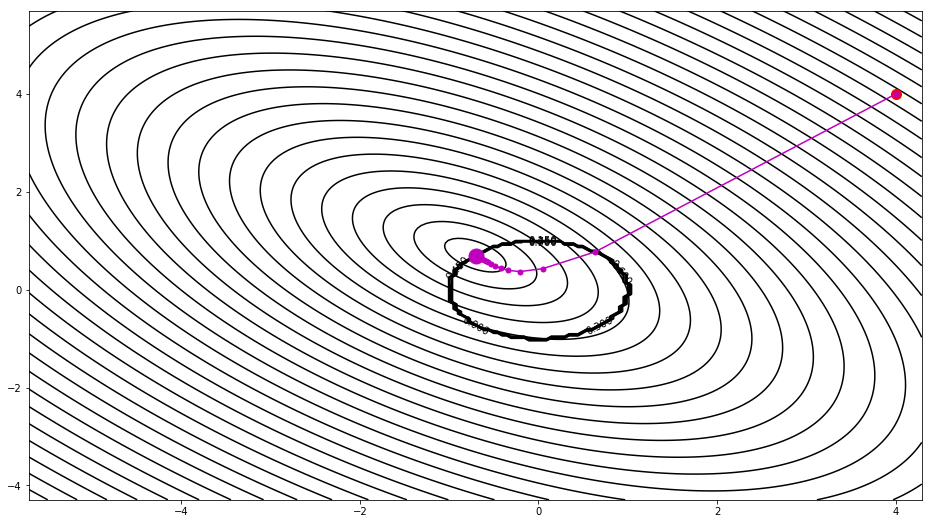

In [15]:
def callback(x):
    mhist.append(x)

# linear term
m = np.array([-2., 2.])
m = m / np.linalg.norm(m)
G = np.array([[10., 3.], 
              [3., 10.]])
d = np.dot(G, m)

# cost function grid
nm1, nm2 = 201, 201
m_min, m_max = (m[0] - 5, m[1] - 5), (m[0] + 5, m[1] + 5)
m1, m2 = np.linspace(m_min[0], m_max[0], nm1), np.linspace(m_min[1], m_max[1], nm2)
m1, m2 = np.meshgrid(m1, m2, indexing='ij')
mgrid = np.vstack((m1.ravel(), m2.ravel()))
J = 0.5 * np.linalg.norm(G @ mgrid - d[:, np.newaxis], axis=0)
J = J.reshape(nm1, nm2)

# indicator term
radius = 1.
indic = np.linalg.norm(mgrid, axis=0) <= radius
indic = indic.reshape(nm1, nm2) 

# proximal gradient
ind = EuclideanBall(np.zeros(2), radius)
l2 = L2(Op=MatrixMult(G), b=d, niter=2)

m0 = np.array([4., 4.])
mhist = [m0,]
L = np.max(np.linalg.eig(G)[0]) # max eigenvalue of G
tau_opt = 1. / L
minv_opt = ProximalGradient(l2, ind, x0=m0, niter=20, callback=callback)
mhist_opt = np.array(mhist)

print(m)
print(np.linalg.solve(G, d))
print(minv_opt)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
cs = ax.contour(m1, m2, J, levels=40, colors='k')
cs = ax.contour(m1, m2, indic, colors='k')
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20)
ax.plot(m0[0], m0[1], '.r', ms=20)
ax.plot(minv_opt[0], minv_opt[1], '.m', ms=30)
ax.plot(mhist_opt[:, 0], mhist_opt[:, 1], '.-m', ms=10);

In [16]:
minv_opt = ProximalGradient(l2, ind, x0=m0, niter=20, callback=callback)



## ADMM

Let's go back to this cost function and use ADMM

$$
\mathbf{x} = arg min_\mathbf{x} \frac{1}{2} ||\mathbf{A} \mathbf{x} - \mathbf{b} ||_2^2 + \epsilon ||\mathbf{x}||_1
$$

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 8.409426e-02	niter = 100

   Itn       x[0]          f           g       J = f + g
     1   8.89594e-06   1.050e+00   1.635e+00   2.684e+00
     2   6.64197e-05   1.729e+00   8.674e-01   2.596e+00
     3  -3.21530e-05   1.620e+00   7.353e-01   2.356e+00
     4  -3.81360e-05   1.419e+00   8.573e-01   2.276e+00
     5  -1.94912e-05   1.259e+00   9.205e-01   2.179e+00
     6  -3.29841e-06   1.152e+00   1.039e+00   2.190e+00
     7   3.56493e-06   1.045e+00   1.084e+00   2.129e+00
     8   4.71883e-06   9.746e-01   1.102e+00   2.076e+00
     9   3.77724e-06   9.262e-01   1.109e+00   2.035e+00
    10   2.51188e-06   8.924e-01   1.108e+00   2.000e+00
    11   1.51101e-06   8.686e-01   1.102e+00   1.970e+00
    21  -5.63317e-09   6.368e-01   1.276e+00   1.913e+00
    31  -8.75090e-10   6.056e-01   1.294e+00  

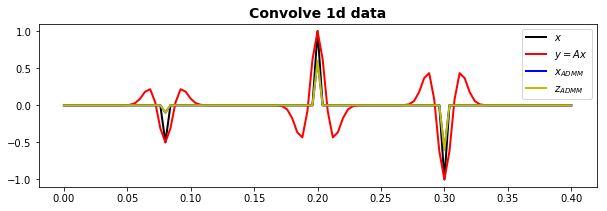

In [17]:
nt = 101
dt = 0.004
t = np.arange(nt)*dt
h, th, hcenter = ricker(t[:101], f0=30)

x = np.zeros(nt)
x[nt//5] = -.5
x[nt//2] = 1
x[3*nt//4] = -1

Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
y = Cop*x

l1 = L1()
l2 = L2(Op=Cop, b=y, niter=30)

tau = np.real(1./(Cop.H*Cop).eigs(neigs=1, which='LM')[0]) # optimal tau=1/maxeig(Cop^H Cop)
epsg = 100
xinv_hist = []
xinv, zinv = ADMM(l2, l1, tau=tau, x0=np.zeros_like(x), niter=100, callback=callback, show=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, y, 'r', lw=2, label=r'$y=Ax$')
ax.plot(t, xinv, 'b', lw=2, label=r'$x_{ADMM}$')
ax.plot(t, zinv, 'y', lw=2, label=r'$z_{ADMM}$')
ax.set_title('Convolve 1d data', fontsize=14, fontweight='bold')
ax.legend();

## Linearized-ADMM

First we solve the same problem as ADMM (in the case $\mathbf{A}=\mathbf{I}$)

$$
\mathbf{x} = arg min_\mathbf{x} \frac{1}{2} ||\mathbf{A} \mathbf{x} - \mathbf{b} ||_2^2 + \epsilon ||\mathbf{I} \mathbf{x}||_1
$$

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.Identity.Identity'>
tau = 1.000000e+00	mu = 9.900000e-01	niter = 100

   Itn       x[0]          f           g       J = f + g
     1  -1.65798e-03   8.473e-02   4.005e+00   4.090e+00
     2  -8.41399e-04   2.203e-01   3.342e+00   3.562e+00
     3  -3.22195e-04   3.748e-01   2.874e+00   3.249e+00
     4   3.32104e-04   5.332e-01   2.535e+00   3.069e+00
     5   7.65354e-04   6.887e-01   2.295e+00   2.983e+00
     6   9.55440e-04   7.105e-01   2.151e+00   2.862e+00
     7   9.63653e-04   6.714e-01   2.156e+00   2.828e+00
     8   8.91211e-04   6.201e-01   2.273e+00   2.893e+00
     9   7.40316e-04   5.809e-01   2.195e+00   2.776e+00
    10   5.51812e-04   5.602e-01   2.023e+00   2.583e+00
    11   3.82140e-04   5.561e-01   1.821e+00   2.378e+00
   

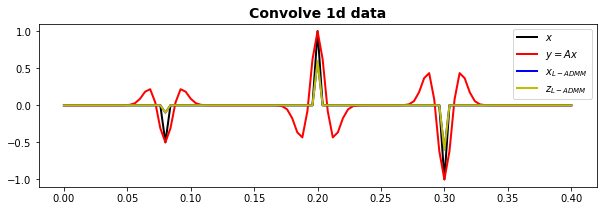

In [18]:
nt = 101
dt = 0.004
t = np.arange(nt)*dt
h, th, hcenter = ricker(t[:101], f0=30)

x = np.zeros(nt)
x[nt//5] = -.5
x[nt//2] = 1
x[3*nt//4] = -1

Cop = Convolve1D(nt, h=h, offset=hcenter, dtype='float32')
y = Cop*x

l1 = L1()
l2 = L2(Op=Cop, b=y, niter=30)
Aop = Identity(nt)

L = (Aop.H*Aop).eigs(neigs=1, which='LM')[0]
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

epsg = 100
xinv_hist = []
xinv, zinv = LinearizedADMM(l2, l1, Aop, tau=tau, mu=mu, x0=np.zeros_like(x), niter=100, 
                            callback=callback, show=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, y, 'r', lw=2, label=r'$y=Ax$')
ax.plot(t, xinv, 'b', lw=2, label=r'$x_{L-ADMM}$')
ax.plot(t, zinv, 'y', lw=2, label=r'$z_{L-ADMM}$')
ax.set_title('Convolve 1d data', fontsize=14, fontweight='bold')
ax.legend();

We try now to solve a problem where $\mathbf{A}$ is not an identify.

More specifically we consider a denoising problem and we try to enforce blockyness in our solution)

$$
\mathbf{x} = arg min_\mathbf{x} \frac{\sigma}{2} ||\mathbf{x} - \mathbf{y} ||_2^2 + ||\mathbf{D} \mathbf{x}||_1
$$

Linearized-ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L2.L2'>
Linear operator (A): <class 'pylops.basicoperators.FirstDerivative.FirstDerivative'>
tau = 1.000000e+00	mu = 2.475599e-01	niter = 50

   Itn       x[0]          f           g       J = f + g
     1   2.62901e+00   1.855e+03   8.539e+01   1.941e+03
     2   4.44283e+00   1.234e+03   8.714e+01   1.321e+03
     3   5.76139e+00   8.425e+02   9.570e+01   9.382e+02
     4   6.74553e+00   5.958e+02   1.012e+02   6.970e+02
     5   7.50093e+00   4.403e+02   1.036e+02   5.439e+02
     6   8.09275e+00   3.426e+02   1.041e+02   4.467e+02
     7   8.56215e+00   2.813e+02   1.037e+02   3.850e+02
     8   8.93721e+00   2.429e+02   1.029e+02   3.457e+02
     9   9.23848e+00   2.189e+02   1.018e+02   3.207e+02
    10   9.48155e+00   2.040e+02   1.009e+02   3.048e+02
    11   9.67834e+00   1.948e+02   9.997e+01   

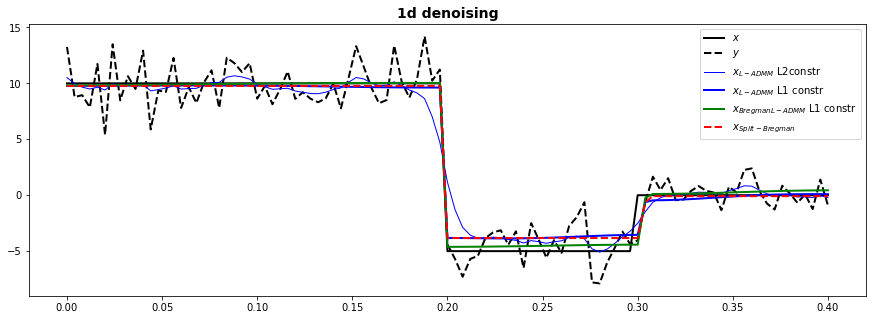

In [19]:
np.random.seed(1)

nx = 101
x = np.zeros(nx)
x[:nx//2] = 10
x[nx//2:3*nx//4] = -5
n = np.random.normal(0, 2, nx)
y = x + n

l2 = L2(b=y)
Dop = FirstDerivative(nx, edge=True, kind='backward')

L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

# L-ADMM with l2 constraint
l21 = L2(sigma=5.)
xladmm2, zladmm2 = LinearizedADMM(l2, l21, Dop, tau=tau, mu=mu, x0=np.zeros_like(x), niter=50, show=True)

# L-ADMM with l1 constraint
l1 = L1(sigma=10.)
xladmm, zladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=np.zeros_like(x), niter=50)

# Split-Bregman
mu = 0.01
lamda = 0.3
niter = 100
niterinner = 3
xsb = SplitBregman(Identity(nx), [Dop], y, niter, niterinner, mu=mu, epsRL1s=[lamda],
                   tol=1e-4, tau=1, **dict(iter_lim=30, damp=1e-3))[0]

# Bregman L-ADMM
L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1 # optimal tau=1/maxeig(I^H I)
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

l1 = L1(sigma=20.)
l2 = L2(b=y, alpha=20., qgrad=False)
xb = Bregman(l2, l1, x0=np.zeros_like(x), solver=LinearizedADMM, 
             A=Dop, niterouter=2, **dict(tau=tau, mu=mu, niter=100))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, y, '--k', lw=2, label=r'$y$')
ax.plot(t, xladmm2, 'b', lw=1, label=r'$x_{L-ADMM}$ L2constr')
ax.plot(t, xladmm, 'b', lw=2, label=r'$x_{L-ADMM}$ L1 constr')
ax.plot(t, xb, 'g', lw=2, label=r'$x_{Bregman L-ADMM}$ L1 constr')
ax.plot(t, xsb, '--r', lw=2, label=r'$x_{Split-Bregman}$')
ax.set_title('1d denoising', fontsize=14, fontweight='bold')
ax.legend();

## Primal-Dual

We can also use the Primal-dual algorithm to solve this problem

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.FirstDerivative.FirstDerivative'>
Additional vector (z): None
tau = 1.000000e+00	mu = 2.475599e-01
theta = 0.00		niter = 100

   Itn       x[0]          f           g       J = f + g
     1   6.62435e+00   7.218e+02   5.155e+02   1.237e+03
     2   9.65973e+00   1.984e+02   5.988e+02   7.972e+02
     3   1.08321e+01   9.306e+01   4.799e+02   5.730e+02
     4   1.11204e+01   9.422e+01   3.618e+02   4.560e+02
     5   1.10528e+01   1.120e+02   3.178e+02   4.298e+02
     6   1.08858e+01   1.224e+02   2.809e+02   4.034e+02
     7   1.07227e+01   1.250e+02   2.384e+02   3.634e+02
     8   1.05916e+01   1.248e+02   2.073e+02   3.321e+02
     9   1.04908e+01   1.252e+02   1.956e+02   3.208e+02
    10   1.04119e+01   1.271e+02   1.

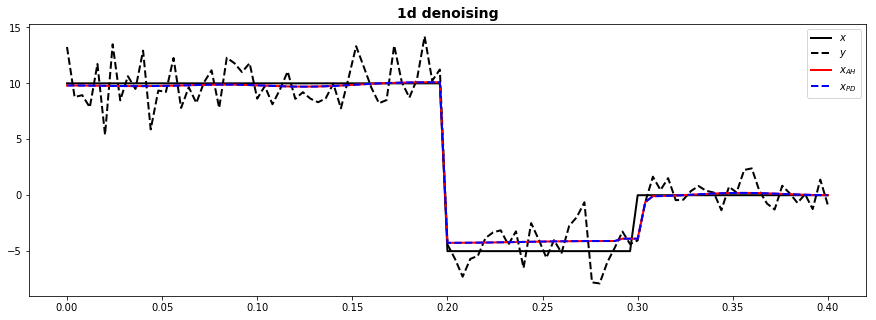

In [20]:
# Primal-dual
L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

l2 = L2(b=y)
l1 = L1(sigma=5.)
xah = PrimalDual(l2, l1, Dop, tau=tau, mu=mu, theta=0., 
                 x0=np.zeros_like(x), niter=100, show=True)
xpd = PrimalDual(l2, l1, Dop, tau=tau, mu=mu, theta=1., 
                 x0=np.zeros_like(x), niter=100, show=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(t, x, 'k', lw=2, label=r'$x$')
ax.plot(t, y, '--k', lw=2, label=r'$y$')
ax.plot(t, xah, 'r', lw=2, label=r'$x_{AH}$')
ax.plot(t, xpd, '--b', lw=2, label=r'$x_{PD}$')
ax.set_title('1d denoising', fontsize=14, fontweight='bold')
ax.legend();